In [47]:
import os
import glob
import numpy as np
import zipfile
import concurrent.futures
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## This code reads multiple zip files that contain multiple CSV files of sensor data, extracts the required data from them, and combines them into a single pandas DataFrame. The extracted data includes ACC, BVP, EDA, HR, IBI, and TEMP. The extract_data function takes in a list of zip file names, iterates through the files, and for each file, extracts the required data and renames the columns. The extracted data is then joined to create a single DataFrame. The function returns this DataFrame after dropping any rows that contain missing values. The main part of the code uses the glob module to get a list of all the folders that contain the zip files. It then iterates over these folders and extracts data from all the zip files in each folder using the extract_data function. The resulting DataFrames are concatenated into a single DataFrame, and any rows with temporary IBI values are dropped. The resulting DataFrame is returned.

In [6]:
import pandas as pd
import glob
import os
import zipfile

# Set the path to the Excel file containing survey results
survey_results_path = r'SurveyResults.xlsx'

# Read the survey results from Excel and process date-time columns
survey_data = pd.read_excel(survey_results_path, usecols=['ID', 'Start time', 'End time', 'date', 'Stress level'], dtype={'ID': str})
survey_data['Stress level'].replace('na', np.nan, inplace=True)
survey_data.dropna(inplace=True)

survey_data['Start datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['Start time'].map(str))
survey_data['End datetime'] = pd.to_datetime(survey_data['date'].map(str) + ' ' + survey_data['End time'].map(str))
survey_data.drop(['Start time', 'End time', 'date'], axis=1, inplace=True)

# Convert SurveyResults.xlsx to GMT-00:00
daylight = pd.to_datetime(datetime(2020, 11, 1, 0, 0))

# Split survey data into two parts based on daylight saving time
survey_data_part1 = survey_data[survey_data['End datetime'] <= daylight].copy()
survey_data_part1['Start datetime'] = survey_data_part1['Start datetime'].apply(lambda x: x + timedelta(hours=5))
survey_data_part1['End datetime'] = survey_data_part1['End datetime'].apply(lambda x: x + timedelta(hours=5))

survey_data_part2 = survey_data.loc[survey_data['End datetime'] > daylight].copy()
survey_data_part2['Start datetime'] = survey_data_part2['Start datetime'].apply(lambda x: x + timedelta(hours=6))
survey_data_part2['End datetime'] = survey_data_part2['End datetime'].apply(lambda x: x + timedelta(hours=6))

survey_data = pd.concat([survey_data_part1, survey_data_part2], ignore_index=True)
survey_data['duration'] = survey_data['End datetime'] - survey_data['Start datetime']

# Define a function to calculate duration in minutes
def calculate_duration_minutes(duration):
    return duration.seconds / 60

survey_data['duration_minutes'] = survey_data['duration'].apply(calculate_duration_minutes)

survey_data.reset_index(drop=True, inplace=True)

def extract_data(files):
    joined_list = []
    for file in files:
        with zipfile.ZipFile(file) as zf:
            zf.extractall()
            sensor_coords = pd.read_csv('ACC.csv', index_col=None, header=0)
            BVP = pd.read_csv('BVP.csv', index_col=None, header=0)
            eda = pd.read_csv('EDA.csv', index_col=None, header=0)
            heart_rates = pd.read_csv('HR.csv', index_col=None, header=0)
            temp = pd.read_csv('TEMP.csv', index_col=None, header=0)

            sensor_coords = sensor_coords.rename(columns={sensor_coords.columns[0]: 'X_AXIS', sensor_coords.columns[1]: 'Y_AXIS', sensor_coords.columns[2]: 'Z_AXIS'})
            BVP = BVP.rename(columns={BVP.columns[0]: 'BVP'})
            eda = eda.rename(columns={eda.columns[0]: 'EDA'})
            heart_rates = heart_rates.rename(columns={heart_rates.columns[0]: 'HR'})          
            temp = temp.rename(columns={temp.columns[0]: 'TEMP'})
            
            #Creating DateTime attribute for each dataset
            def process_df(df):
                start_timestamp = df.iloc[0,0]
                sample_rate = df.iloc[1,0]
                new_df = pd.DataFrame(df.iloc[2:].values, columns=df.columns)
                new_df['datetime'] = [(start_timestamp + i/sample_rate) for i in range(len(new_df))]
                return new_df
            
            sensor_coords = process_df(sensor_coords)
            BVP = process_df(BVP)
            eda = process_df(eda)
            heart_rates = process_df(heart_rates)
            temp = process_df(temp)
            
            #Merging the Data #taken from original code because this was the best feasible method
            data = sensor_coords.merge(eda, on='datetime', how='outer')
            data = data.merge(BVP, on='datetime', how='outer')
            data = data.merge(heart_rates, on='datetime', how='outer')
            data = data.merge(temp, on='datetime', how='outer')
            
            #Fill Null values with fowrard and backward fill
            data.fillna(method='ffill', inplace=True)
            data.fillna(method='bfill', inplace=True)

            joined_list.append(data)

    df = pd.concat(joined_list).reset_index(drop=True)
    return df

folders = glob.glob(os.path.join("Stress_dataset/*"))
df = pd.concat([extract_data(glob.glob(os.path.join(folder, '*.zip'))) for folder in folders]).reset_index(drop=True)

#Getting Label
df['datetime'] = pd.to_datetime(data['datetime'])
df['id'] = df['id'].astype(str)

def label_data(row_datetime):
    max_datetime = survey_data['End datetime'].max()
    if row_datetime >= max_datetime:
        return 1
    else:
        return 0

df['Label'] = df['datetime'].apply(label_data)

df.to_csv('processed.csv')

In [72]:
# Removing Unnamed column from the dataset
df = pd.read_csv('processed.csv')
df = df.drop('Unnamed: 0', axis=1)

In [73]:
df

,X_AXIS,Y_AXIS,Z_AXIS,id,datetime,EDA,BVP,TEMP,HR,Label
0,-27.0,4.0,56.0,15,1970-01-01 00:00:00.000000032,0.185782,-0.00,31.11,95.98,0
1,-26.0,4.0,57.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
2,-32.0,1.0,59.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
3,-37.0,0.0,57.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
4,-37.0,-1.0,54.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
...,...,...,...,...,...,...,...,...,...,...
27564630,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,93.75,0
27564631,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,94.52,0
27564632,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,95.30,0
27564633,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,96.02,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27564635 entries, 0 to 27564634
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X_AXIS    float64       
 1   Y_AXIS    float64       
 2   Z_AXIS    float64       
 3   id        int64         
 4   datetime  datetime64[ns]
 5   EDA       float64       
 6   BVP       float64       
 7   TEMP      float64       
 8   HR        float64       
 9   Label     int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.1 GB


In [23]:
# Statistics of the data
df.describe()

,X_AXIS,Y_AXIS,Z_AXIS,id,EDA,BVP,TEMP,HR,Label
count,2.756464e+07,2.756464e+07,2.756464e+07,27564635.0,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07,2.756464e+07
mean,-3.449328e+01,-1.842825e+01,8.741106e+00,15.0,1.360729e+00,-6.125526e-01,3.159282e+01,6.871064e+01,6.632067e-02
std,2.984943e+01,4.050797e+01,3.001696e+01,0.0,2.909468e+00,1.228461e+02,1.663991e+00,1.329196e+01,2.488418e-01
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,15.0,0.000000e+00,-3.304690e+03,2.403000e+01,5.050000e+01,0.000000e+00
25%,-5.400000e+01,-5.100000e+01,-1.800000e+01,15.0,1.258520e-01,-1.272000e+01,3.045000e+01,5.800000e+01,0.000000e+00
50%,-4.200000e+01,-8.000000e+00,7.000000e+00,15.0,3.026790e-01,0.000000e+00,3.131000e+01,6.600000e+01,0.000000e+00
75%,-2.700000e+01,1.400000e+01,2.500000e+01,15.0,6.907620e-01,1.682000e+01,3.309000e+01,7.900000e+01,0.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,15.0,4.357153e+01,3.678620e+03,3.637000e+01,1.586500e+02,1.000000e+00


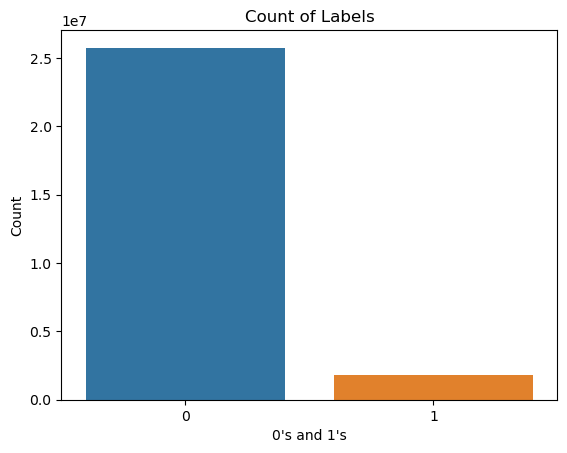

In [25]:
#Check imbalance of data
sns.countplot(x='Label', data=df)
plt.title("Count of Labels")
plt.xlabel("0's and 1's")
plt.ylabel("Count")
plt.show()

In [26]:
#Imbalanced data count 
df['Label'].value_counts()

0    25736530
1     1828105
Name: Label, dtype: int64

# Resampling

## This code is performing upsampling on a Pandas DataFrame df which has a column named 'target'. First, it is creating two new DataFrames: df_Z which contains all rows from df where the value in the 'target' column is 0, and df_O which contains all rows where the value in the 'target' column is 1. Then, it is upsampling the df_Z DataFrame to a size of 0's. . Finally, it is concatenating the upsampled df_Z DataFrame with the df_O DataFrame using the pd.concat() method with ignore_index=True. This creates a new DataFrame with the same columns as df, where the rows are from df_Z and the remaining rows are from df_O. The resulting DataFrame is returned and may be used for further analysis or modeling. The purpose of this downsampling is likely to address class imbalance in the target variable, where there are many more rows with a target value of 0 than 1. By upsampling the minority class, the resulting DataFrame has a more balanced distribution of target values, which can improve model performance for certain types of models.

In [27]:
#upsampling 1's to balance the data to match 0's shape
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

sm = SMOTE()  

X = df.drop({'Label','datetime'},axis = 1)
Y = df['Label']   
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

dependent, label = sm.fit_resample(X_train, y_train.ravel())

df = dependent.copy()
df['Label'] = label

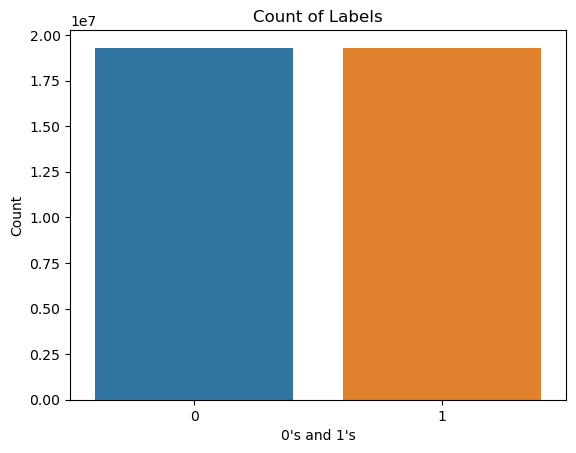

In [29]:
#Balanced data label coutn visual representation
sns.countplot(x='Label', data=df)
plt.title("Count of Labels")
plt.xlabel("0's and 1's")
plt.ylabel("Count")
plt.show()

In [30]:
df.shape

(38604284, 9)

In [31]:
#Balanced data count
df['Label'].value_counts()

0    19302142
1    19302142
Name: Label, dtype: int64

In [32]:
#Correlation matrix
df.corr()

,X_AXIS,Y_AXIS,Z_AXIS,id,EDA,BVP,TEMP,HR,Label
X_AXIS,1.000000,-0.143553,0.240115,NaN,-0.113858,0.077614,-0.094069,0.123719,0.045489
Y_AXIS,-0.143553,1.000000,0.157212,NaN,0.114220,-0.121767,0.057626,-0.194138,-0.089502
Z_AXIS,0.240115,0.157212,1.000000,NaN,-0.173379,-0.035375,-0.068698,0.032145,-0.045839
id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDA,-0.113858,0.114220,-0.173379,NaN,1.000000,-0.041505,0.310030,0.006128,0.103205
BVP,0.077614,-0.121767,-0.035375,NaN,-0.041505,1.000000,-0.021062,-0.033716,-0.013732
TEMP,-0.094069,0.057626,-0.068698,NaN,0.310030,-0.021062,1.000000,0.013083,0.109424
HR,0.123719,-0.194138,0.032145,NaN,0.006128,-0.033716,0.013083,1.000000,0.214428
Label,0.045489,-0.089502,-0.045839,NaN,0.103205,-0.013732,0.109424,0.214428,1.000000


In [33]:
df.corr().transpose()

,X_AXIS,Y_AXIS,Z_AXIS,id,EDA,BVP,TEMP,HR,Label
X_AXIS,1.000000,-0.143553,0.240115,NaN,-0.113858,0.077614,-0.094069,0.123719,0.045489
Y_AXIS,-0.143553,1.000000,0.157212,NaN,0.114220,-0.121767,0.057626,-0.194138,-0.089502
Z_AXIS,0.240115,0.157212,1.000000,NaN,-0.173379,-0.035375,-0.068698,0.032145,-0.045839
id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDA,-0.113858,0.114220,-0.173379,NaN,1.000000,-0.041505,0.310030,0.006128,0.103205
BVP,0.077614,-0.121767,-0.035375,NaN,-0.041505,1.000000,-0.021062,-0.033716,-0.013732
TEMP,-0.094069,0.057626,-0.068698,NaN,0.310030,-0.021062,1.000000,0.013083,0.109424
HR,0.123719,-0.194138,0.032145,NaN,0.006128,-0.033716,0.013083,1.000000,0.214428
Label,0.045489,-0.089502,-0.045839,NaN,0.103205,-0.013732,0.109424,0.214428,1.000000


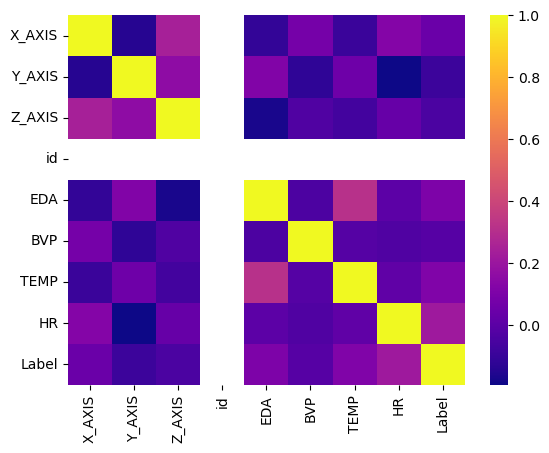

In [34]:
#Correlation heatmap visulisation
sns.heatmap(df.corr().transpose(), cmap='plasma')
plt.show()

array([[<AxesSubplot:title={'center':'X_AXIS'}>,
        <AxesSubplot:title={'center':'Y_AXIS'}>,
        <AxesSubplot:title={'center':'Z_AXIS'}>],
       [<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'EDA'}>,
        <AxesSubplot:title={'center':'BVP'}>],
       [<AxesSubplot:title={'center':'TEMP'}>,
        <AxesSubplot:title={'center':'HR'}>,
        <AxesSubplot:title={'center':'Label'}>]], dtype=object)

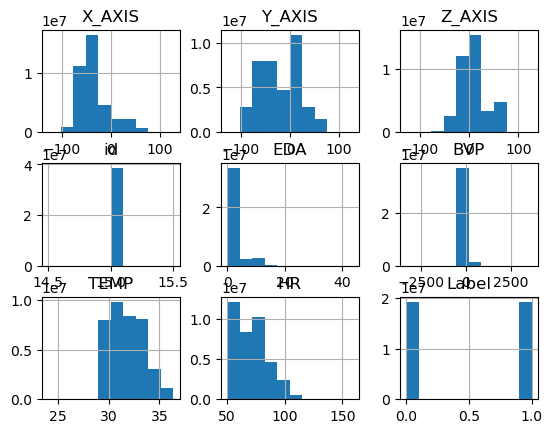

In [35]:
#histogram to check if the data is normally distributed or not
df.hist()

# Time series alanysis

In [68]:
df

,Unnamed: 0,accelerometer_X,accelerometer_Y,accelerometer_Z,id,datetime,EDA,BVP,temp,heart_rate,Label
0,0,-27.0,4.0,56.0,15,1970-01-01 00:00:00.000000032,0.185782,-0.00,31.11,95.98,0
1,1,-26.0,4.0,57.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
2,2,-32.0,1.0,59.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
3,3,-37.0,0.0,57.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
4,4,-37.0,-1.0,54.0,15,1970-01-01 00:00:00.000000031,0.185782,-0.00,31.11,95.98,0
...,...,...,...,...,...,...,...,...,...,...,...
27564630,819642,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,93.75,0
27564631,819643,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,94.52,0
27564632,819644,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,95.30,0
27564633,819645,-10.0,-59.0,22.0,15,1970-01-01 00:00:00.000000094,0.278333,-23.27,32.16,96.02,0


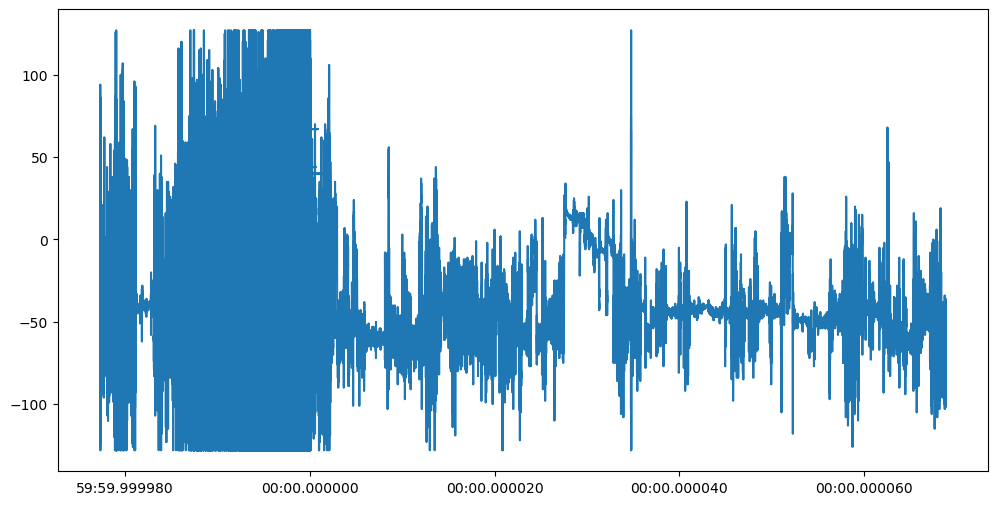

In [75]:
plt.figure(figsize=(12, 6))
print(plt.plot(df.datetime,df.X_AXIS))

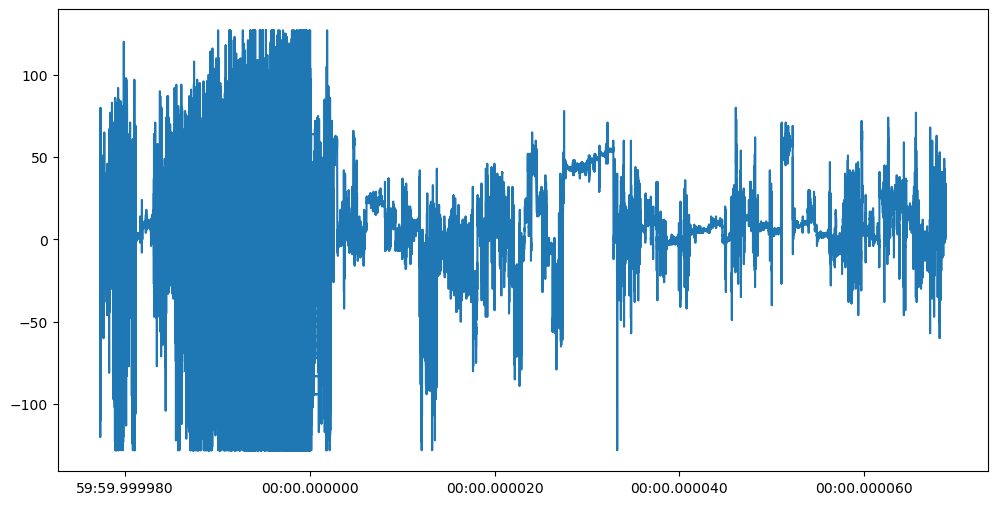

In [76]:
plt.figure(figsize=(12, 6))
print(plt.plot(df.datetime,df.Y_AXIS))

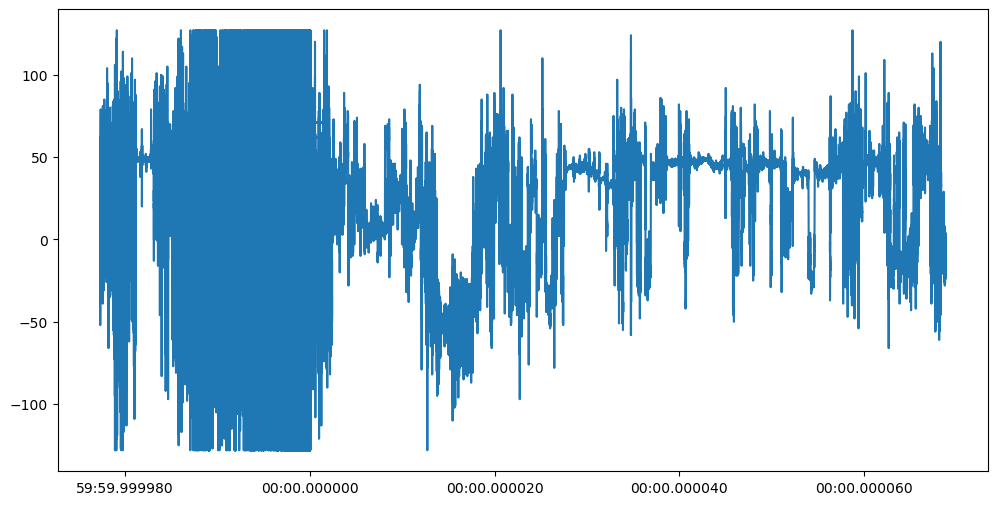

In [77]:
plt.figure(figsize=(12, 6))
print(plt.plot(df.datetime,df.Z_AXIS))

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38604284 entries, 0 to 38604283
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   X_AXIS  float64
 1   Y_AXIS  float64
 2   Z_AXIS  float64
 3   id      int64  
 4   EDA     float64
 5   BVP     float64
 6   TEMP    float64
 7   HR      float64
 8   Label   int64  
dtypes: float64(7), int64(2)
memory usage: 2.6 GB


# Train-Test Split

In [41]:
#75% training and 25% testing
training = df.iloc[:int(df.shape[0] * 0.75)]
testing = df.iloc[int(df.shape[0] * 0.75):]

X_train = training.drop({'Label','id'}, axis=1)
y_train = training['Label']
X_test = testing.drop({'Label','id'}, axis=1)
y_test = testing['Label']

# Output the shapes of the split data
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28953213, 7) (28953213,) (9651071, 7) (9651071,)


# Standard-Scaler to scale the data into 0-1 range

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [44]:
X_train

array([[ 2.43068062, -1.26183575, -0.43882165, ...,  0.75946443,
        -1.23419584,  0.80242144],
       [ 0.7827312 , -0.943987  ,  0.47088691, ..., -0.29783408,
        -0.93464971,  0.91022986],
       [ 0.05763345, -1.53078469, -0.87682948, ..., -1.75052194,
        -0.71897649, -0.41940737],
       ...,
       [ 0.2224284 , -0.60168834,  0.47088691, ...,  0.26705705,
         0.23957114,  0.92101071],
       [ 3.32057331, -1.09068642,  0.16765072, ...,  0.53374902,
         1.3658646 ,  1.05397443],
       [-0.40379238,  1.40320378, -0.97790821, ...,  0.14447172,
         1.8691021 ,  0.95191579]])

In [45]:
X_test

array([[-7.42024996e-02, -1.70193402e+00,  2.01343631e-01, ...,
         6.19145548e-01,  1.36586460e+00, -8.86577213e-01],
       [-9.31136200e-01, -4.79438823e-01, -8.13826958e-04, ...,
         1.24170093e-02,  9.34518168e-01, -1.28187477e+00],
       [-6.34505304e-01,  6.20806852e-01,  2.35036540e-01, ...,
        -3.64603211e+00,  4.07316972e-01,  9.51197065e-01],
       ...,
       [ 2.43068062e+00, -1.26183575e+00, -4.38821652e-01, ...,
         1.22950415e-01,  1.27000984e+00,  8.23271084e-03],
       [ 5.76334543e-02, -1.53078469e+00, -8.76829477e-01, ...,
         1.24170093e-02, -7.18976490e-01, -4.19407373e-01],
       [ 7.82731201e-01, -9.43986997e-01,  4.70886908e-01, ...,
         1.24170093e-02, -9.34649707e-01,  9.10229863e-01]])

## This code is performing several steps to create and train an LSTM (Long Short-Term Memory) model for binary classification. First, it imports the StandardScaler class from the sklearn.preprocessing module and uses it to normalize the input data in a pandas DataFrame called "df". This step scales the data so that each feature has a mean of 0 and a standard deviation of 1, making it easier for the model to learn from. Then, it splits the data into training and testing sets using the train_test_split function from the sklearn.model_selection module. The X variable is assigned the features from the DataFrame, except for the last column, which contains the target variable. The y variable is assigned the target variable. Next, the data is converted to arrays using the numpy module. The training and testing arrays are then reshaped into the input format required for an LSTM model, which expects a 3D input shape of (samples, timesteps, features). The LSTM layer is added to the Sequential model, along with a Dense output layer with a sigmoid activation function. Finally, the model is compiled with binary cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric. The model is trained using the fit method, with the training data, validation data, and other hyperparameters such as the number of epochs and batch size specified. After training, the model is ready to make predictions on new data.

# Logistic Regression

In [54]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [56]:
clf = LogisticRegression(random_state=0).fit(X_train,y_train)
pred = clf.predict(X_test)

In [62]:
print(classification_report(y_test, pred))

               precision    recall  f1-score   support
                                                      
           0        0.66      0.70      0.68   4729024
           1        0.70      0.66      0.68   4922047
                                                      
    accuracy                            0.68   9651071
   macro avg        0.68      0.68      0.68   9651071
weighted avg        0.68      0.68      0.68   9651071


# Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train,y_train)

In [58]:
clf_pred = RF.predict(X_test)

In [63]:
print(classification_report(y_test, clf_pred))

               precision    recall  f1-score   support
                                                      
           0        0.88      0.87      0.91   4729024
           1        0.87      0.88      0.91   4922047
                                                      
    accuracy                            0.91   9651071
   macro avg        0.91      0.91      0.91   9651071
weighted avg        0.91      0.91      0.91   9651071


# LSTM

In [51]:
X_train = X_train
X_test = X_test
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=1, batch_size=64, validation_data=(X_test, y_test))


452394/452394 [==============================] - 648s 1ms/step - loss: 0.0705 - accuracy: 0.9764 - val_loss: 0.0373 - val_accuracy: 0.9971


In [53]:
from sklearn.metrics import accuracy_score
# evaluate the model on the testing data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {accuracy}")

301596/301596 [==============================] - 179s 592us/step
Accuracy score: 0.9970903747366484
